In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor as xgbr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sns

import warnings 
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('../input/flight-price-prediction/Clean_Dataset.csv')

In [5]:
df = pd.DataFrame(data)
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## Data Exploring

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [7]:
df.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [8]:
df.describe()

,Unnamed: 0,duration,days_left,price
count,300153.000000,300153.000000,300153.000000,300153.000000
mean,150076.000000,12.221021,26.004751,20889.660523
std,86646.852011,7.191997,13.561004,22697.767366
min,0.000000,0.830000,1.000000,1105.000000
25%,75038.000000,6.830000,15.000000,4783.000000
50%,150076.000000,11.250000,26.000000,7425.000000
75%,225114.000000,16.170000,38.000000,42521.000000
max,300152.000000,49.830000,49.000000,123071.000000


## Data Visualization

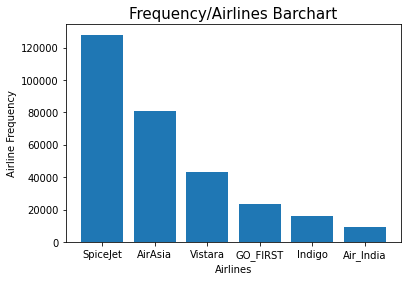

In [9]:
# Ploting graph of airline bookings to visually represent the bookings count.
plt.bar(df.airline.unique(), df.airline.value_counts())
plt.title("Frequency/Airlines Barchart", fontsize=15)
plt.xlabel("Airlines")
plt.ylabel("Airline Frequency")
plt.show()

From the visualization above, it is clear that the SpiceJet and AirAsia are generally preferred by travellers. Could this be due to the price or something else? Lets find out.

Text(0, 0.5, 'Mean Prices')

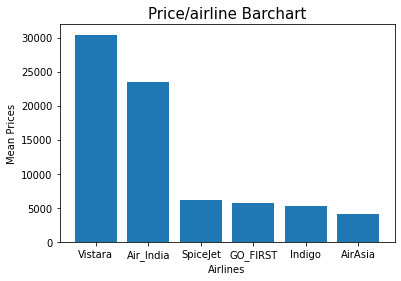

In [10]:
grouped_airlines_by_prices = df.groupby('airline')['price'].mean().sort_values(ascending= False) #Sorted series of airline prices (Grouped by airline)
plt.bar(grouped_airlines_by_prices.index, grouped_airlines_by_prices.values) #plotting mean prices against airline
plt.title("Price/airline Barchart", fontsize=15)
plt.xlabel("Airlines")
plt.ylabel("Mean Prices")

> Based off the visualization above, we can see that ticket prices do vary with Airlines with Vistara and Air_india topping the chart (Most expensive)

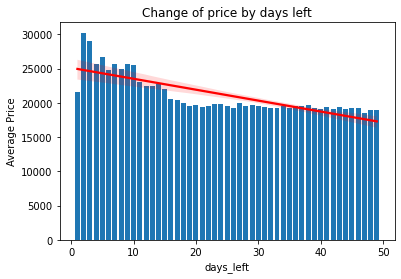

In [11]:
# grouping of days left by average prices
grouped_airlines_by_days_left = df.groupby('days_left')['price'].mean()
plt.bar(grouped_airlines_by_days_left.index, grouped_airlines_by_days_left.values)
plt.title("Change of price by days left")
plt.xlabel("Number of days left")
plt.ylabel("Average Price")
sns.regplot(x = grouped_airlines_by_days_left.index, y = grouped_airlines_by_days_left.values, color ='red', scatter=False)
plt.show()

> Based off the visualizations, We can see that ticket prices on an average are high when there are few days left to depature and are less expensive with more days till depature... As the mean cost slopes downward as the number of days increase

In [12]:
depatures = df['departure_time'].unique()
arrivals = df['arrival_time'].unique()
print('List of depature times\n', depatures)
print('List of arrival times\n', arrivals)

List of depature times
 ['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
List of arrival times
 ['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']


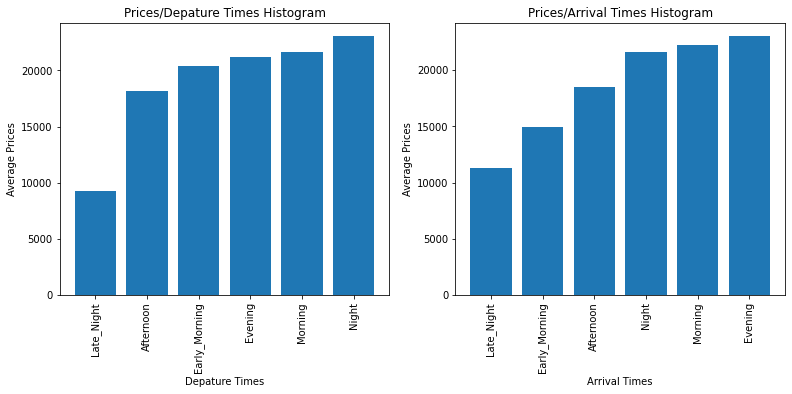

In [14]:
# grouping of arrival and depature time by average prices sorted in ascending order
depature_time_price = df.groupby('departure_time')['price'].mean().round(0).sort_values(ascending = True)
arrival_time_price = df.groupby('arrival_time')['price'].mean().round(0).sort_values(ascending = True)

plt.figure(figsize =(13,5))
plt.subplot(1,2,1)
plt.bar(depature_time_price.index, depature_time_price.values)
plt.title("Prices/Depature Times Histogram")
plt.xlabel("Depature Times")
plt.ylabel("Average Prices")
plt.xticks(rotation = 'vertical')

plt.subplot(1,2,2)
plt.bar(arrival_time_price.index, arrival_time_price.values)
plt.title("Prices/Arrival Times Histogram")
plt.xlabel("Arrival Times")
plt.ylabel("Average Prices")
plt.xticks(rotation = 'vertical')

plt.show()

* Based off the two visualizations above, we can observe the following;
1. Source Cities
    * Flights that start from Dehli are the cheapest
    * Flights that start from Chennai are most expensive
2. Destination Cities
    * Flights with destination Delhi are the cheapest
    * Flights with Destination Kolkata are the most expensive

In [15]:
classes = df['class'].unique()
print("Classes\n", classes)

Classes
 ['Economy' 'Business']


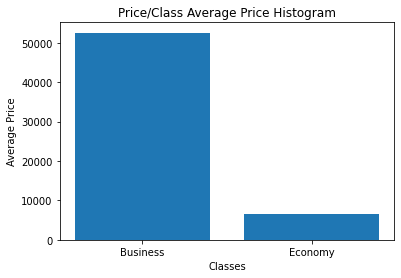

The ratio business to economy is 7.99 or 8:1


In [16]:
# grouping of flight class by average prices
economy_business_prices = df.groupby('class')['price'].mean().round(0)

plt.bar(economy_business_prices.index, economy_business_prices.values)
plt.title("Price/Class Average Price Histogram")
plt.xlabel("Classes")
plt.ylabel("Average Price")
plt.show()

# Ratio calculation
ratio = economy_business_prices.values[0]/economy_business_prices.values[1]
print('The ratio business to economy is',ratio.round(2), 'or 8:1')

> Based off the visualization above, we can see that an average Business class ticket is significantly more expensive than an Economy class ticket

In [18]:
stops = df['stops'].unique()
print("Number of stops\n", stops)

Number of stops
 ['zero' 'one' 'two_or_more']


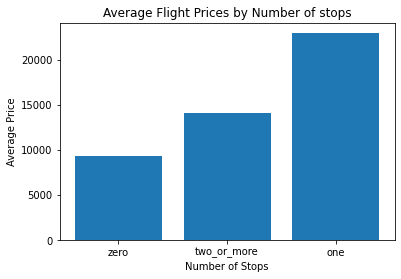

In [19]:
stops = df.groupby('stops')['price'].mean().round(0).sort_values(ascending= True)
plt.bar(stops.index, stops.values)
plt.title("Average Flight Prices by Number of stops")
plt.xlabel("Number of Stops")
plt.ylabel("Average Price")
plt.show()

> From the visualization above, we can see that flight prices are indeed affected by the number of stops throughout the journey

## Pre-processing Data for model

In [25]:
# Dropping the 'flight' column because the flight ID is not a strong determinant.
df_2 = df.drop(['flight'], ['Unnamed: 0'], axis=1)
df_2.head(3)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956


In [26]:
# Converting all non float, integer values into category data type

df_2['airline'] = df_2['airline'].astype('category')
df_2['source_city'] = df_2['source_city'].astype('category')
df_2['departure_time'] = df_2['departure_time'].astype('category')
df_2['stops'] = df_2['stops'].astype('category')
df_2['arrival_time'] = df_2['arrival_time'].astype('category')
df_2['destination_city'] = df_2['destination_city'].astype('category')
df_2['class'] = df_2['class'].astype('category')
print("Formatted Data Types\n",df_2.dtypes)

Formatted Data Types
 airline             category
flight                object
source_city         category
departure_time      category
stops               category
arrival_time        category
destination_city    category
class               category
duration             float64
days_left              int64
price                  int64
dtype: object


In [27]:
# Creating of new dataset(dummy dataset), separating the prefixes with '_' and dropping each first column of
# the newly created data set in order to avoid Dummy Variable trap
df_2 = pd.get_dummies(df_2,prefix_sep='_',drop_first=True)
df_2.head()

,duration,days_left,price,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_6E-105,flight_6E-113,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai,class_Economy
0,2.17,1,5953,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,2.33,1,5953,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,2.17,1,5956,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,2.25,1,5955,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
4,2.33,1,5955,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,1


In [28]:
# Splitting data set into independent and dependent set
# With test size of 20% and random_state/seed of 32
x = df_2.drop('price', axis= 1)
y = df_2['price']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size= 0.2, random_state= 32)

In [29]:
print('length of training set', len(x_train))
print('length of testing set', len(x_test))

length of training set 240122
length of testing set 60031


## Model Training

### Linear Regression

In [30]:
# Model Training 

linear_r = LinearRegression()
linear_r.fit(x_train, y_train)

LinearRegression()

In [31]:
# Model details
print('---Linear Regression---')
test_pred_l = linear_r.predict(x_test) # predicting test data
train_pred_l = linear_r.predict(x_train) # predicting train data

print("Model Intercept", (linear_r.intercept_).round(3))
print("Model Score on train data", ((r2_score(y_train, train_pred_l)*100).round(3)),'%')
print("Model Score on test data", ((r2_score(y_test,test_pred_l)*100).round(3)),'%')

---Linear Regression---
Model Intercept 51180.412
Model Score on train data 92.583 %
Model Score on test data 92.639 %


> From the results above, we can tell that the model hasn't over fitted because there is very little difference beteen the scores on the test data and train data

### XG Boost Regressor

In [32]:
xgb_model = xgbr(objective = 'reg:squarederror',n_jobs=8, tree_method='exact', learning_rate = 0.1, max_depth = 9, n_estimators = 50)
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [33]:
# Model details
print('---XGBoost Regressor---')
test_pred_xgb = xgb_model.predict(x_test) # predicting test data
train_pred_xgb = xgb_model.predict(x_train) # predicting train data

print("Model Score on train data", ((r2_score(y_train, train_pred_xgb)*100).round(3)),'%')
print("Model Score on test data", ((r2_score(y_test,test_pred_xgb)*100).round(3)),'%')

---XGBoost Regressor---
Model Score on train data 97.525 %
Model Score on test data 97.422 %


> From the results above, we can tell that the model hasn't over fitted because there is very little difference beteen the scores on the test data and train data

## Take away points
1. The XGBoost Regressor model works better here as the score is greater than that of the LinearRegression.
2. SpiceJet and AirAsia are generally preferred by travellers.
3. Ticket prices vary with airlines.
4. Ticket prices on an average are high when there are few days left to depature and are less expensive with more days till depature
5. 
    * Depature Times
        * Late night flights are the cheapest
        * Night flights are the most expensive
    * Arrival Times
        * Late night flights are the cheapest
        * Evening flights are the most expensive
6. 
    * Source Cities
        * Flights that start from Dehli are the cheapest
        * Flights that start from Chennai are most expensive
    * Destination Cities
        * Flights with destination Delhi are the cheapest
        * Flights with Destination Kolkata are the most expensive
7. On an average, Business class ticket are significantly more expensive than an Economy class ticket
> The data set used in this project was gotten from [Here](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction)